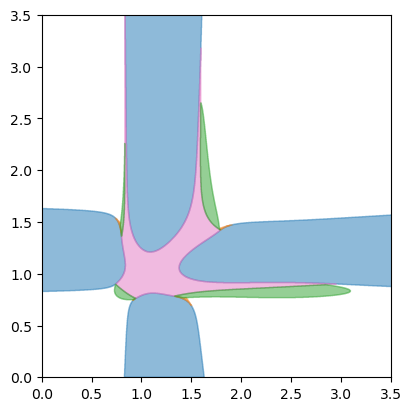

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as mpatches
import os

from cal_omega_barV import get_bar_v_omega
from general_PD import find_long_instabi, find_short_instabi, find_contours


def get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, bar_vA=1, bar_vB=1, kappa=0.7,
                            extent=[0, 4, 0, 4], qmin=1e-5, qmax=1, Nq=200, resolution=1000, overwrite=False, ll=3./20, simple_gamma=False):
    if simple_gamma:
        folder = "data/PD_pA_pB_SG/"
    elif ll == 0.:
        folder = "data/PD_pA_pB_woS/"
    else:
        folder = "data/PD_pA_pB/"
    fout = "%se%g_%g_%g_%g_D%g_%g_r%g_%g_qm%g_r%g.npz" % (
        folder, etaAA, etaAB, etaBA, etaBB, Dr_A, Dr_B, bar_rho_A, bar_rho_B, qmax, resolution
    )
    if not overwrite and os.path.exists(fout):
        with np.load(fout, "rb") as data:
            return data["extent"], data["state"], data["q_range"]
    else:
        nrows, ncols = resolution, resolution
        pA = np.linspace(extent[0], extent[1], ncols)
        pB = np.linspace(extent[2], extent[3], nrows)
        pA_2D, pB_2D = np.meshgrid(pA, pB)
        vA_0, vB_0, wAA, wAB, wBA, wBB = get_bar_v_omega(
            etaAA, etaAB, etaBA, etaBB, pA_2D, pB_2D, bar_rho_A, bar_rho_B, bar_vA, bar_vB, kappa)
        w1 = 1 + wAA
        w2 = 1 + wBB
        wc = wAB * wBA
        sigma_D = Dr_A / Dr_B
        sigma_v = vA_0 / vB_0
        Pe = vB_0 / Dr_B

        mask_LS, mask_LOI, mask_LSI = find_long_instabi(sigma_D, sigma_v, Pe, w1, w2, wc, q0=qmin, ll=ll, simple_gamma=simple_gamma)
        q0_a4, q0_Delta3 = np.zeros((2, nrows, ncols))
        for row in range(nrows):
            for col in range(ncols):
                if mask_LS[row, col]:
                    q0_a4[row, col], q0_Delta3[row, col] = find_short_instabi(
                        sigma_D, sigma_v[row, col], Pe[row, col], w1[row, col], w2[row, col], wc[row, col], qmin=qmin, qmax=qmax, Nq=Nq, ll=ll, simple_gamma=simple_gamma)
        state = np.zeros((nrows, ncols), dtype=np.byte)
        state[mask_LSI] = 1
        state[mask_LOI] = 2
        state[q0_a4 > 0] = 3
        state[q0_Delta3 > 0] = 4
        q_range = np.array([qmin, qmax, Nq])
        np.savez_compressed(fout, extent=extent, state=state, q_range=q_range)
        return extent, state, q_range


def plot_PD_composition(state, extent, xlim=None, ylim=None, ax=None, fill=True, set_xy_lims=True, scale_factor=1.):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    # ax.imshow(state, origin="lower", extent=extent)
    contours = find_contours(state)
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:blue", alpha=0.5)
        else:
            ax.plot(x * scale_factor, y * scale_factor, c="tab:blue", lw=1)
    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:pink", alpha=0.5)
        else:
            ax.plot(x * scale_factor, y * scale_factor, c="tab:pink", lw=1)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:orange", alpha=0.5)
        else:
            ax.plot(x * scale_factor, y * scale_factor, c="tab:orange", lw=1)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:green", alpha=0.5)
        else:
            ax.plot(x * scale_factor, y * scale_factor, c="tab:green", lw=1)
    # # ax.plot(1, 1, "o", ms=2, c="k")

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    if set_xy_lims:
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()


def plot_state(state, extent, xlim=None, ylim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    im = ax.imshow(state, origin="lower", extent=extent)
    fig.colorbar(im, ax=ax)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()

def plot_PD_composition_Turing(state, extent, xlim=None, ylim=None, ax=None, fill=True, set_xy_lims=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
        flag_show = True
    else:
        flag_show = False
    nrows, ncols = state.shape
    contours = find_contours(state)
    x_center = None
    y_center = None
    for contour in contours["LWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        
        if fill:
            if x[0] == x[-1]:
                ax.fill(x, y, c="tab:blue", alpha=0.5)
            else:
                if x_center is None:
                    x_center = x
                    y_center = y
                else:
                    if y[0] != y_center[0]:
                        x_center = np.hstack((x_center, x))
                        y_center = np.hstack((y_center, y))
                    else:
                        x_center = np.hstack((x_center, x[::-1]))
                        y_center = np.hstack((y_center, y[::-1]))
        else:
            ax.plot(x, y, c="tab:blue", lw=1)
    if fill:
        ax.fill(x_center, y_center, c="tab:blue", alpha=0.5)

    for contour in contours["LWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:pink", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:pink", lw=1)
    
    for contour in contours["SWS"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:orange", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:orange", lw=1)


    for contour in contours["SWO"]:
        x = (contour[:, 1] / ncols) * (extent[1] - extent[0]) + extent[0]
        y = (contour[:, 0] / nrows) * (extent[3] - extent[2]) + extent[2]
        if fill:
            ax.fill(x, y, c="tab:green", alpha=0.5)
        else:
            ax.plot(x, y, c="tab:green", lw=1)

    if xlim is None:
        xlim = [extent[0], extent[1]]
    if ylim is None:
        ylim = [extent[2], extent[3]]
    if set_xy_lims:
        ax.set_xlim(xlim[0], xlim[1])
        ax.set_ylim(ylim[0], ylim[1])
    if flag_show:
        plt.show()
        plt.close()

# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000, ll=0.)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

# extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2, Nq=400, resolution=4000)
# plot_PD_composition(state, extent, xlim=[0, 3], ylim=[0, 3])

Dr = 0.1
etaAA = -2
etaBB = -2
etaAB = 0.5
etaBA = -0.5
# plot_PD_composition(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
extent, state, q_range = get_PD_composition_data(etaAA, etaAB, etaBA, etaBB, Dr, Dr, 1, 1, qmax=2.5, Nq=400, resolution=2000)
plot_PD_composition(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])
# plot_state(state, extent, xlim=[0, 3.5], ylim=[0, 3.5])


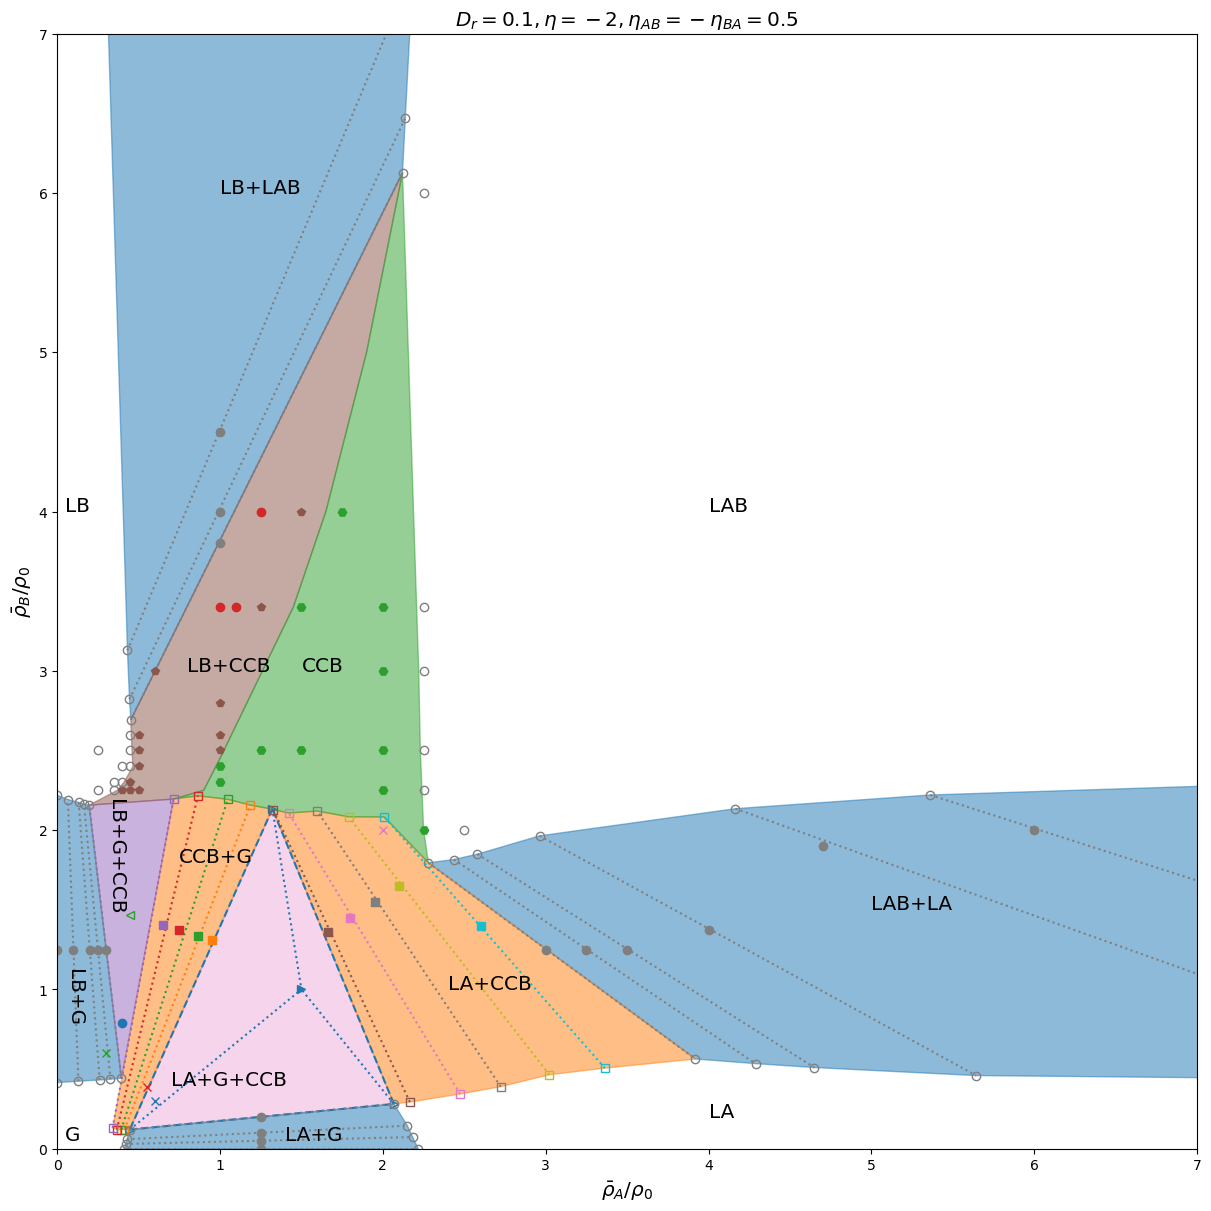

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# from profile import plot_time_ave_density_profile_SP


def get_slope(p1, p2):
    return (p1[1] - p2[1]) / (p1[0] - p2[0])

def plot_tri(ax, edge, center, c, linestyle="dashed"):
    for i in range(len(edge)):
        ax.plot([edge[i-1][0], edge[i][0]], [edge[i-1][1], edge[i][1]], c=c, linestyle=linestyle)
        ax.plot([edge[i][0], center[0]], [edge[i][1], center[1]], c=c, linestyle="dotted")

def plot_bi(ax, edge, c, linestyle="dotted"):
    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], c=c, linestyle=linestyle)


def plot_tie_lines(ax, centers, edges, marker="o", c=None):
    for i, center in enumerate(centers):
        x = [j[0] for j in edges[i]]
        y = [j[1] for j in edges[i]]
        line, = ax.plot(center[0], center[1], marker, c=c)
        ax.plot(x, y, marker, fillstyle="none", c=line.get_c())
        plot_bi(ax, edges[i], line.get_c())


def fill_color(edge, ax, c="tab:blue"):
    n = len(edge)
    x, y = [], []
    for p in edge:
        x.append(p[0][0])
        y.append(p[0][1])
    for p in edge[::-1]:
        x.append(p[1][0])
        y.append(p[1][1])
    ax.fill(x, y, c=c, alpha=0.5)


if __name__ == "__main__":
    fig, ax = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)

    # LB + DC + G
    center_3p = [15, 10]
    edge_3p = [[13.215, 21.3376], [4.4581, 1.1997], [20.6741, 2.8125]]
    x = [i[0] for i in edge_3p]
    y = [i[1] for i in edge_3p]
    line, = ax.plot(center_3p[0], center_3p[1], ">")
    ax.plot(x, y, ">", fillstyle="none", c=line.get_c())
    plot_tri(ax, edge_3p, center_3p, line.get_c())

    x = [i[0] for i in edge_3p]
    y = [i[1] for i in edge_3p]
    ax.fill(x, y, c="tab:pink", alpha=0.3)

    # DC + G
    center_G_DC = [[9.5, 13.075], [8.625, 13.36], [7.5, 13.725], [6.5, 14.05]]
    edge_G_DC = [[[4.1251, 1.2010], [11.8641, 21.5710]],
                 [[3.9359, 1.1988], [10.4761, 21.9334]],
                 [[3.6668, 1.2039], [8.644, 22.1592]],
                 [[3.404, 1.3104], [7.1505, 21.9526]]
                ]
    plot_tie_lines(ax, center_G_DC, edge_G_DC, "s")
    fill_color([[edge_3p[1], edge_3p[0]]] + edge_G_DC, ax, c="tab:orange")

    # G + LA
    center_G_LA = [
        [12.5, 0],
        [12.5, 0.5],
        [12.5, 1],
        [12.5, 2],
        # [12.5, 3]
    ]
    edge_G_LA = [
        [[4.1229, 0], [22.1689, 0]],
        [[4.1984, 0.2967], [21.8290, 0.7313]],
        [[4.2891, 0.5983], [21.5045, 1.4470]],
        [[4.4534, 1.2062], [20.6741, 2.8125]],
        # [[4.6308, 1.7986], [19.6164, 4.1027]]
    ]
    plot_tie_lines(ax, center_G_LA, edge_G_LA, c="tab:grey")
    fill_color(edge_G_LA, ax)


    # G + LB
    center_G_LB = [[0, 12.5], [1, 12.5], [2, 12.5], [2.5, 12.5], [3, 12.5]]
    edge_G_LB = [
        [[0, 4.1531], [0, 22.1902]],
        [[1.3039, 4.2378], [0.6576, 21.9206]],
        [[2.6128, 4.3159], [1.3177, 21.7441]],
        [[3.2733, 4.3624], [1.6440, 21.6433]],
        [[3.9437, 4.4311], [1.9665, 21.5689]]
    ]
    plot_tie_lines(ax, center_G_LB, edge_G_LB, c="tab:grey")
    fill_color(edge_G_LB, ax)
    
    # LB + LAB
    center_LB_LAB = [[10, 45], [10, 40], [10, 38]]
    edge_LB_LAB = [
        [[4.3168, 31.2870], [21.8533, 73.9867]],
        [[4.4412, 28.2210], [21.3746, 64.7041]],
        [[4.5254, 26.9304], [21.2044, 61.2696]]
    ]
    plot_tie_lines(ax, center_LB_LAB, edge_LB_LAB, c="tab:grey")
    fill_color([[[3, 75], [22, 76]]] + edge_LB_LAB, ax, c="tab:blue")

    # LAB + LA
    center_LAB_LA = [
        # [130/4, 40/4],
        [120/4, 50/4],
        [130/4, 50/4],
        [140/4, 50/4],
        [160/4, 55/4],
        # [45, 15],
        [47, 19],
        [60, 20]]
    edge_LAB_LA = [
        # [[90.3333/4, 70.2929/4], [152.7865/4, 22.8993/4]],
        [[91.1910/4, 71.7885/4], [156.7620/4, 22.5345/4]], 
        [[97.4319/4, 72.6223/4], [171.5426/4, 21.3663/4]],
        [[103.2168/4, 73.9762/4], [185.9900/4, 20.3843/4]],
        [[118.4965/4, 78.5602/4], [225.7040/4, 18.3693/4]],
        # [[36.65, 19.], [66.4, 4.578]],
        [[41.6492, 21.3472], [88.2805, 4.2819]],
        [[53.6089, 22.2076], [108.7682, 4.1077]]
    ]
    plot_tie_lines(ax, center_LAB_LA, edge_LAB_LA, c="tab:grey")
    fill_color(edge_LAB_LA + [[[108, 24], [108.7682, 4.1077]]], ax, c="tab:blue")

    # DC + LA
    center_LA_DC = [
        [16.6, 13.6],
        [18, 14.5],
        [19.5, 15.5],
        [21, 16.5],
        [52/2, 28/2]
        # [104/4, 56/4]
    ]
    edge_LA_DC = [
        [[21.6557, 2.9274], [13.2678, 21.2943]],
        [[24.7437, 3.4352], [14.2187, 21.0731]],
        [[27.2349, 3.8950], [15.9725, 21.1980]],
        [[30.2194, 4.6432], [17.8965, 20.8375]],
        [[67.2622/2, 10.1195/2], [40.1760/2, 41.6459/2]]
        # [[134.0522/4, 19.6533/4], [79.7745/4, 87.2652/4]]
    ]
    plot_tie_lines(ax, center_LA_DC, edge_LA_DC, "s")
    edge = [[edge_3p[2], edge_3p[0]]] + edge_LA_DC + [edge_LAB_LA[0][::-1]]
    fill_color(edge, ax, c="tab:orange")

    # DC + G + LB
    edge_G_LB_DC = [[3.9437, 4.4311], [1.9665, 21.5689], [7.1505, 21.9526]]
    x = [i[0] for i in edge_G_LB_DC]
    y = [i[1] for i in edge_G_LB_DC]
    ax.fill(x, y, c="tab:purple", alpha=0.5)

    # LB + DC
    edge_LB_DC = [
        [edge_G_LB_DC[1], edge_G_LB_DC[2]],
        [[3.7, 22.5], [9, 22.5]],
        [[4.1, 23.0], [10, 24.5]],
        [[4.65, 24.0], [14.5, 34]],
        [[4.6, 25.0], [16.5, 40]],
        [[4.55, 26.0], [19.0, 50]],
        edge_LB_LAB[-1]
    ]
    fill_color(edge_LB_DC, ax, c="tab:brown")

    # DC
    edge_DC = [p[1] for p in edge_LB_DC[::-1]] + [p[1] for p in edge_G_DC[::-1]] + [p[1] for p in edge_LA_DC]
    edge_DC.append(edge_LAB_LA[0][0])
    edge_DC += [
        [22.5, 20],
        [22.4, 22.5],
        [22.3, 25],
        [22.2, 30],
        edge_LB_LAB[-1][1]
    ]
    x = [i[0] for i in edge_DC]
    y = [i[1] for i in edge_DC]
    ax.fill(x, y, c="tab:green", alpha=0.5)

    plt.plot(10, 23, 'H', c="tab:green")
    plt.plot(10, 24, 'H', c="tab:green")
    plt.plot(12.5, 25, 'H', c="tab:green")
    plt.plot(15, 25, 'H', c="tab:green")

    plt.plot(10, 25, 'p', c="tab:brown")
    plt.plot(10, 26, 'p', c="tab:brown")
    plt.plot(10, 28, 'p', c="tab:brown")

    plt.plot(10, 34, "o", c="tab:red")

    plt.plot(4.5, 14.7, "<", fillstyle="none", c="tab:green")
    # plt.plot(4, 12.5, "<", fillstyle="none", c="tab:green")


    plt.plot(3, 6, "x", c="tab:green")
    plt.plot(5.5, 3.85, "x", c="tab:red")
    plt.plot(6, 3, "x", c="tab:blue")
    # plt.plot(6.5, 1.6, "x", c="tab:blue")

    plt.plot(20, 20, "x", c="tab:pink")

    plt.plot(2.5, 22.5, "o", c="tab:grey", fillstyle="none")
    plt.plot(3.5, 22.5, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.0, 22.5, "p", c="tab:brown")
    plt.plot(4.5, 22.5, "p", c="tab:brown")
    plt.plot(5, 22.5, "p", c="tab:brown")

    plt.plot(3.5, 23, "o", c="tab:grey", fillstyle="none")
    plt.plot(4, 23, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.5, 23, "p", c="tab:brown")

    plt.plot(4, 24, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.5, 24, "o", c="tab:grey", fillstyle="none")
    plt.plot(5, 24, "p", c="tab:brown")

    plt.plot(2.5, 25, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.5, 25, "o", c="tab:grey", fillstyle="none")
    plt.plot(5, 25, "p", c="tab:brown")
    plt.plot(4.5, 26, "o", c="tab:grey", fillstyle="none")
    plt.plot(5, 26, "p", c="tab:brown")
    plt.plot(6, 30, "p", c="tab:brown")


    plt.plot(25, 20, "o", c="tab:grey", fillstyle="none")
    plt.plot(22.5, 20, "H", c="tab:green")
    plt.plot(22.5, 22.5, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 22.5, "H", c="tab:green")
    plt.plot(22.5, 25, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 25, "H", c="tab:green")
    plt.plot(22.5, 30, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 30, "H", c="tab:green")

    plt.plot(22.5, 34, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 34, "H", c="tab:green")



    plt.plot(15, 34, "H", c="tab:green")
    plt.plot(12.5, 34, "p", c="tab:brown")
    plt.plot(11, 34, "o", c="tab:red")
    plt.plot(17.5, 40, "H", c="tab:green")
    plt.plot(15, 40, "p", c="tab:brown")
    plt.plot(12.5, 40, "o", c="tab:red")
    # plt.plot(20, 60, "o", c="tab:blue")
    plt.plot(22.5, 60, "o", c="tab:grey", fillstyle="none")
    # plt.plot(22.5, 50, "o", c="tab:grey", fillstyle="none")

    # plt.plot(4.4, 23.6, "*", c="k")
    # plt.plot(21.8, 56.5, "*", c="k")
    # plt.plot(10, 34, "*", c="k")
    # plt.plot(12.5, 10, "x", c="k")

    # plt.plot(3, 17.3, "o")
    plt.plot(4, 7.9, "o")



    # plt.plot(6, 30, "x")
    # plt.plot(5, 30, "x")

    # plt.plot(15, 50, "x")
    # plt.plot(15, 40, "x")

    # plt.plot(110/4, 50/4, "o")
    # plt.plot(115/4, 50/4, "*")
    # plt.plot(116/4, 50/4, "*")

    # plt.plot(130/4, 50/4, "p")
    # plt.plot(4, 8, "p")
    # plt.plot(4.3, 8, "p")


    # ax.set_xlim(0, 110)
    # ax.set_ylim(0, 75)

    ax.set_xlim(0, 70)
    ax.set_ylim(0, 70)
    ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
    ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

    ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7])

    ax.set_title(r"$D_r=0.1, \eta=-2,\eta_{AB}=-\eta_{BA}=0.5$", fontsize="x-large")

    ax.text(40, 40, "LAB", fontsize="x-large")
    ax.text(15, 30, "CCB", fontsize="x-large")
    ax.text(40, 2, "LA", fontsize="x-large")
    ax.text(0.5, 0.5, "G", fontsize="x-large")
    ax.text(0.5, 40, "LB", fontsize="x-large")
    ax.text(10, 60, "LB+LAB", fontsize="x-large")
    ax.text(0.5, 8, "LB+G", fontsize="x-large", rotation=-90)
    ax.text(8, 30, "LB+CCB", fontsize="x-large")
    ax.text(3, 15, "LB+G+CCB", fontsize="x-large", rotation=-90)
    ax.text(7.5, 18, "CCB+G", fontsize="x-large", rotation=0)
    ax.text(7, 4, "LA+G+CCB", fontsize="x-large", rotation=0)
    ax.text(14, 0.5, "LA+G", fontsize="x-large", rotation=0)
    ax.text(24, 10, "LA+CCB", fontsize="x-large", rotation=0)
    ax.text(50, 15, "LAB+LA", fontsize="x-large", rotation=0)

    # plot_PD_composition(state, extent, ax=ax, fill=False, set_xy_lims=False, scale_factor=10)

    plt.show()
    plt.close()
        


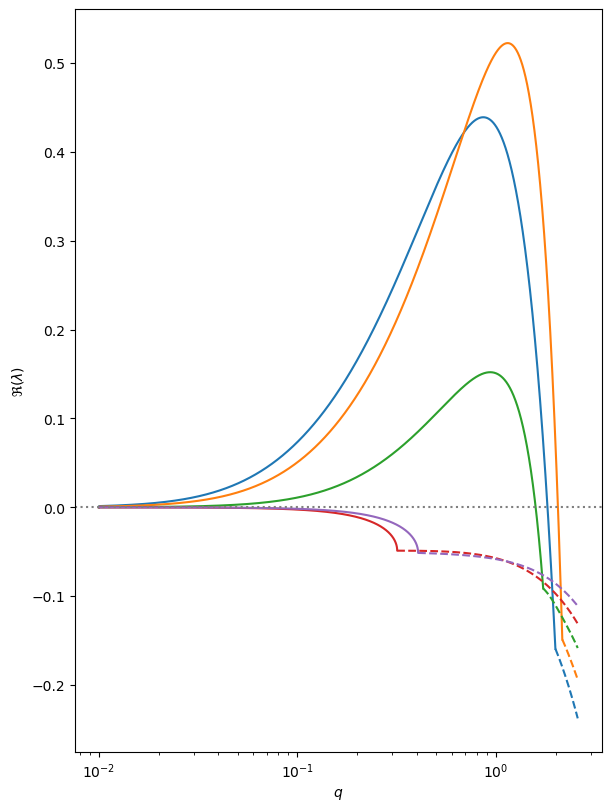

In [3]:
from NRQS_Turing import DMatrix_w_surface_tension, DMatrix
# q_arr = np.linspace(1e-6, np.sqrt(20/3), 1000)
q_arr = np.logspace(-2, np.log10(np.sqrt(20/3)), 100000, endpoint=False)

def plot_lambda(x, y, ax, threshold=1e-8):
    mask_r = np.abs(y.imag) <= threshold
    turning_pts = [0]
    states = [mask_r[0]]
    for i in range(x.size):
        if states[-1] != mask_r[i]:
            turning_pts.append(i)
            states.append(mask_r[i])
    turning_pts.append(x.size)
    line = None
    for i, s in enumerate(states):
        beg, end = turning_pts[i], turning_pts[i+1]
        xx = x[beg:end]
        yy = y[beg:end].real
        if s:
            ls = "-"
        else:
            ls = "--"
        if line is None:
            line, = ax.plot(xx, yy, ls)
        else:
            ax.plot(xx, yy, ls, c=line.get_c())


eta_AA = -2
eta_BB = -2
eta_AB = 0.5
eta_BA = -0.5
wc = eta_AB * eta_BA
sigma = 1
Dr = 0.1
fig, ax = plt.subplots(figsize=(6, 8), constrained_layout=True)

phiA = 1.25
phiB = 4

for phiA in [1, 1.25, 1.5, 1.75, 2]:    
    M = DMatrix_w_surface_tension(eta_AA, eta_AB, eta_BA, eta_BB, phiA=phiA, phiB=phiB, Dr_A=Dr, Dr_B=Dr, bar_vA=1, bar_vB=1, w_v2_over_q=True)
    # M = DMatrix(eta_AA, eta_AB, eta_BA, eta_BB, phiA=phiA, phiB=phiB, Dr_A=Dr, Dr_B=Dr, bar_vA=1, bar_vB=1)

    lamb = M.get_lambda_q(q_arr).max(axis=1)
    # mask_q = np.logical_and(q_arr < 2, q_arr>1.4e-2)
    # q_arr = q_arr[mask_q]
    # lamb = lamb[mask_q]
    # mask_r = np.abs(lamb.imag) <= 1e-8
    # mask_i = mask_r == False

    # line, = plt.plot(q_arr[mask_r], lamb[mask_r].real)
    # plt.plot(q_arr[mask_i], lamb[mask_i].real , "--", c=line.get_c())
    # line, = plt.plot(q_arr, np.abs(lamb.imag) * Dr[i], c=c_list[i])
    plot_lambda(q_arr, lamb, ax)

# ax.set_ylim(-0.05, 0.1)
# ax.set_xlim(1e-2, 2.5)
ax.set_xscale("log")
ax.axhline(0, c="tab:grey", linestyle="dotted")
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$\Re(\lambda)$")
plt.show()
plt.close()

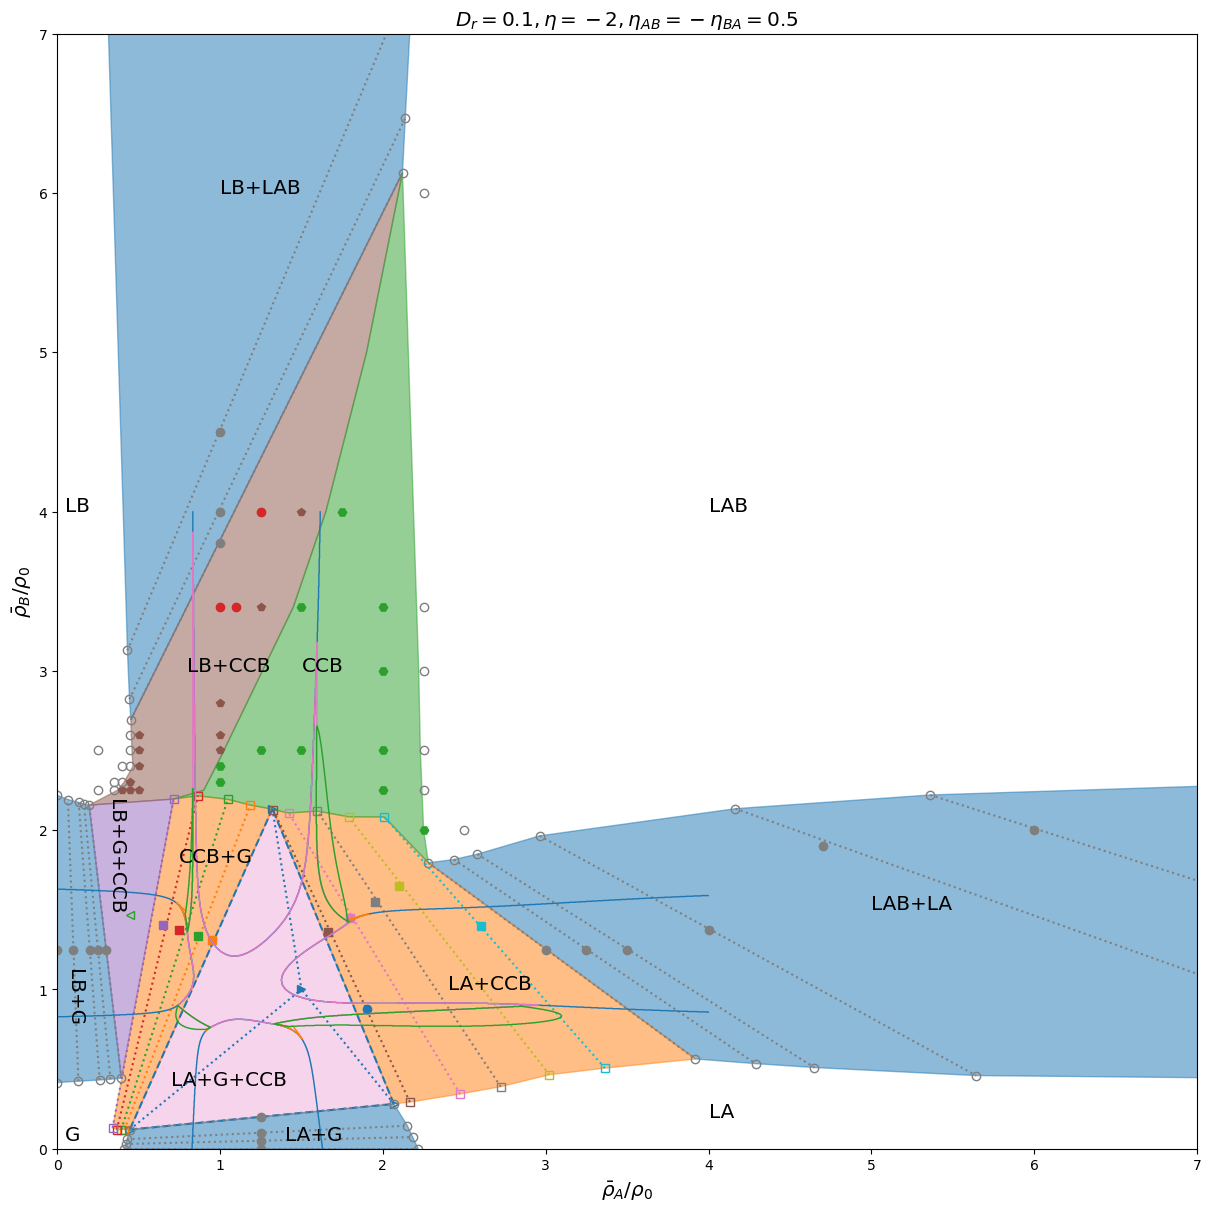

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# from profile import plot_time_ave_density_profile_SP


def get_slope(p1, p2):
    return (p1[1] - p2[1]) / (p1[0] - p2[0])

def plot_tri(ax, edge, center, c, linestyle="dashed"):
    for i in range(len(edge)):
        ax.plot([edge[i-1][0], edge[i][0]], [edge[i-1][1], edge[i][1]], c=c, linestyle=linestyle)
        ax.plot([edge[i][0], center[0]], [edge[i][1], center[1]], c=c, linestyle="dotted")

def plot_bi(ax, edge, c, linestyle="dotted"):
    ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], c=c, linestyle=linestyle)


def plot_tie_lines(ax, centers, edges, marker="o", c=None):
    for i, center in enumerate(centers):
        x = [j[0] for j in edges[i]]
        y = [j[1] for j in edges[i]]
        line, = ax.plot(center[0], center[1], marker, c=c)
        ax.plot(x, y, marker, fillstyle="none", c=line.get_c())
        plot_bi(ax, edges[i], line.get_c())


def fill_color(edge, ax, c="tab:blue"):
    n = len(edge)
    x, y = [], []
    for p in edge:
        x.append(p[0][0])
        y.append(p[0][1])
    for p in edge[::-1]:
        x.append(p[1][0])
        y.append(p[1][1])
    ax.fill(x, y, c=c, alpha=0.5)


if __name__ == "__main__":
    fig, ax = plt.subplots(1, 1, figsize=(12, 12), constrained_layout=True)

    # LB + DC + G
    center_3p = [15, 10]
    edge_3p = [[13.215, 21.3376], [4.4581, 1.1997], [20.6741, 2.8125]]
    x = [i[0] for i in edge_3p]
    y = [i[1] for i in edge_3p]
    line, = ax.plot(center_3p[0], center_3p[1], ">")
    ax.plot(x, y, ">", fillstyle="none", c=line.get_c())
    plot_tri(ax, edge_3p, center_3p, line.get_c())

    x = [i[0] for i in edge_3p]
    y = [i[1] for i in edge_3p]
    ax.fill(x, y, c="tab:pink", alpha=0.3)

    # DC + G
    center_G_DC = [[9.5, 13.075], [8.625, 13.36], [7.5, 13.725], [6.5, 14.05]]
    edge_G_DC = [[[4.1251, 1.2010], [11.8641, 21.5710]],
                 [[3.9359, 1.1988], [10.4761, 21.9334]],
                 [[3.6668, 1.2039], [8.644, 22.1592]],
                 [[3.404, 1.3104], [7.1505, 21.9526]]
                ]
    plot_tie_lines(ax, center_G_DC, edge_G_DC, "s")
    fill_color([[edge_3p[1], edge_3p[0]]] + edge_G_DC, ax, c="tab:orange")

    # G + LA
    center_G_LA = [
        [12.5, 0],
        [12.5, 0.5],
        [12.5, 1],
        [12.5, 2],
        # [12.5, 3]
    ]
    edge_G_LA = [
        [[4.1229, 0], [22.1689, 0]],
        [[4.1984, 0.2967], [21.8290, 0.7313]],
        [[4.2891, 0.5983], [21.5045, 1.4470]],
        [[4.4534, 1.2062], [20.6741, 2.8125]],
        # [[4.6308, 1.7986], [19.6164, 4.1027]]
    ]
    plot_tie_lines(ax, center_G_LA, edge_G_LA, c="tab:grey")
    fill_color(edge_G_LA, ax)


    # G + LB
    center_G_LB = [[0, 12.5], [1, 12.5], [2, 12.5], [2.5, 12.5], [3, 12.5]]
    edge_G_LB = [
        [[0, 4.1531], [0, 22.1902]],
        [[1.3039, 4.2378], [0.6576, 21.9206]],
        [[2.6128, 4.3159], [1.3177, 21.7441]],
        [[3.2733, 4.3624], [1.6440, 21.6433]],
        [[3.9437, 4.4311], [1.9665, 21.5689]]
    ]
    plot_tie_lines(ax, center_G_LB, edge_G_LB, c="tab:grey")
    fill_color(edge_G_LB, ax)
    
    # LB + LAB
    center_LB_LAB = [[10, 45], [10, 40], [10, 38]]
    edge_LB_LAB = [
        [[4.3168, 31.2870], [21.8533, 73.9867]],
        [[4.4412, 28.2210], [21.3746, 64.7041]],
        [[4.5254, 26.9304], [21.2044, 61.2696]]
    ]
    plot_tie_lines(ax, center_LB_LAB, edge_LB_LAB, c="tab:grey")
    fill_color([[[3, 75], [22, 76]]] + edge_LB_LAB, ax, c="tab:blue")

    # LAB + LA
    center_LAB_LA = [
        # [130/4, 40/4],
        [120/4, 50/4],
        [130/4, 50/4],
        [140/4, 50/4],
        [160/4, 55/4],
        # [45, 15],
        [47, 19],
        [60, 20]]
    edge_LAB_LA = [
        # [[90.3333/4, 70.2929/4], [152.7865/4, 22.8993/4]],
        [[91.1910/4, 71.7885/4], [156.7620/4, 22.5345/4]], 
        [[97.4319/4, 72.6223/4], [171.5426/4, 21.3663/4]],
        [[103.2168/4, 73.9762/4], [185.9900/4, 20.3843/4]],
        [[118.4965/4, 78.5602/4], [225.7040/4, 18.3693/4]],
        # [[36.65, 19.], [66.4, 4.578]],
        [[41.6492, 21.3472], [88.2805, 4.2819]],
        [[53.6089, 22.2076], [108.7682, 4.1077]]
    ]
    plot_tie_lines(ax, center_LAB_LA, edge_LAB_LA, c="tab:grey")
    fill_color(edge_LAB_LA + [[[108, 24], [108.7682, 4.1077]]], ax, c="tab:blue")

    # DC + LA
    center_LA_DC = [
        [16.6, 13.6],
        [18, 14.5],
        [19.5, 15.5],
        [21, 16.5],
        [52/2, 28/2]
        # [104/4, 56/4]
    ]
    edge_LA_DC = [
        [[21.6557, 2.9274], [13.2678, 21.2943]],
        [[24.7437, 3.4352], [14.2187, 21.0731]],
        [[27.2349, 3.8950], [15.9725, 21.1980]],
        [[30.2194, 4.6432], [17.8965, 20.8375]],
        [[67.2622/2, 10.1195/2], [40.1760/2, 41.6459/2]]
        # [[134.0522/4, 19.6533/4], [79.7745/4, 87.2652/4]]
    ]
    plot_tie_lines(ax, center_LA_DC, edge_LA_DC, "s")
    edge = [[edge_3p[2], edge_3p[0]]] + edge_LA_DC + [edge_LAB_LA[0][::-1]]
    fill_color(edge, ax, c="tab:orange")

    # DC + G + LB
    edge_G_LB_DC = [[3.9437, 4.4311], [1.9665, 21.5689], [7.1505, 21.9526]]
    x = [i[0] for i in edge_G_LB_DC]
    y = [i[1] for i in edge_G_LB_DC]
    ax.fill(x, y, c="tab:purple", alpha=0.5)

    # LB + DC
    edge_LB_DC = [
        [edge_G_LB_DC[1], edge_G_LB_DC[2]],
        [[3.7, 22.5], [9, 22.5]],
        [[4.1, 23.0], [10, 24.5]],
        [[4.65, 24.0], [14.5, 34]],
        [[4.6, 25.0], [16.5, 40]],
        [[4.55, 26.0], [19.0, 50]],
        edge_LB_LAB[-1]
    ]
    fill_color(edge_LB_DC, ax, c="tab:brown")

    # DC
    edge_DC = [p[1] for p in edge_LB_DC[::-1]] + [p[1] for p in edge_G_DC[::-1]] + [p[1] for p in edge_LA_DC]
    edge_DC.append(edge_LAB_LA[0][0])
    edge_DC += [
        [22.5, 20],
        [22.4, 22.5],
        [22.3, 25],
        [22.2, 30],
        edge_LB_LAB[-1][1]
    ]
    x = [i[0] for i in edge_DC]
    y = [i[1] for i in edge_DC]
    ax.fill(x, y, c="tab:green", alpha=0.5)

    plt.plot(10, 23, 'H', c="tab:green")
    plt.plot(10, 24, 'H', c="tab:green")
    plt.plot(12.5, 25, 'H', c="tab:green")
    plt.plot(15, 25, 'H', c="tab:green")

    plt.plot(10, 25, 'p', c="tab:brown")
    plt.plot(10, 26, 'p', c="tab:brown")
    plt.plot(10, 28, 'p', c="tab:brown")

    plt.plot(10, 34, "o", c="tab:red")

    plt.plot(4.5, 14.7, "<", fillstyle="none", c="tab:green")

    # plt.plot(3, 6, "x", c="tab:green")
    # plt.plot(5.5, 3.85, "x", c="tab:red")
    # plt.plot(6, 3, "x", c="tab:blue")
    # plt.plot(20, 20, "x", c="tab:pink")

    plt.plot(2.5, 22.5, "o", c="tab:grey", fillstyle="none")
    plt.plot(3.5, 22.5, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.0, 22.5, "p", c="tab:brown")
    plt.plot(4.5, 22.5, "p", c="tab:brown")
    plt.plot(5, 22.5, "p", c="tab:brown")

    plt.plot(3.5, 23, "o", c="tab:grey", fillstyle="none")
    plt.plot(4, 23, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.5, 23, "p", c="tab:brown")

    plt.plot(4, 24, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.5, 24, "o", c="tab:grey", fillstyle="none")
    plt.plot(5, 24, "p", c="tab:brown")

    plt.plot(2.5, 25, "o", c="tab:grey", fillstyle="none")
    plt.plot(4.5, 25, "o", c="tab:grey", fillstyle="none")
    plt.plot(5, 25, "p", c="tab:brown")
    plt.plot(4.5, 26, "o", c="tab:grey", fillstyle="none")
    plt.plot(5, 26, "p", c="tab:brown")

    plt.plot(25, 20, "o", c="tab:grey", fillstyle="none")
    plt.plot(22.5, 20, "H", c="tab:green")
    plt.plot(22.5, 22.5, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 22.5, "H", c="tab:green")
    plt.plot(22.5, 25, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 25, "H", c="tab:green")
    plt.plot(22.5, 30, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 30, "H", c="tab:green")

    plt.plot(22.5, 34, "o", c="tab:grey", fillstyle="none")
    plt.plot(20, 34, "H", c="tab:green")



    plt.plot(15, 34, "H", c="tab:green")
    plt.plot(12.5, 34, "p", c="tab:brown")
    plt.plot(11, 34, "o", c="tab:red")
    plt.plot(17.5, 40, "H", c="tab:green")
    plt.plot(15, 40, "p", c="tab:brown")
    plt.plot(12.5, 40, "o", c="tab:red")
    # plt.plot(20, 60, "o", c="tab:blue")
    plt.plot(22.5, 60, "o", c="tab:grey", fillstyle="none")
    # plt.plot(22.5, 50, "o", c="tab:grey", fillstyle="none")

    # plt.plot(4.4, 23.6, "*", c="k")
    # plt.plot(21.8, 56.5, "*", c="k")
    # plt.plot(10, 34, "*", c="k")


    # plt.plot(6, 30, "x")
    # plt.plot(5, 30, "x")

    # plt.plot(15, 50, "x")
    # plt.plot(15, 40, "x")

    # plt.plot(110/4, 50/4, "o")
    # plt.plot(115/4, 50/4, "*")
    # plt.plot(116/4, 50/4, "*")

    # plt.plot(130/4, 50/4, "p")
    # plt.plot(4, 8, "p")
    # plt.plot(4.3, 8, "p")

    plt.plot(19, 8.8, "o")


    # ax.set_xlim(0, 110)
    # ax.set_ylim(0, 75)

    ax.set_xlim(0, 70)
    ax.set_ylim(0, 70)
    ax.set_xlabel(r"$\bar{\rho}_A/\rho_0$", fontsize="x-large")
    ax.set_ylabel(r"$\bar{\rho}_B/\rho_0$", fontsize='x-large')
    ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7])

    ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70])
    ax.set_yticklabels([0, 1, 2, 3, 4, 5, 6, 7])

    ax.set_title(r"$D_r=0.1, \eta=-2,\eta_{AB}=-\eta_{BA}=0.5$", fontsize="x-large")

    ax.text(40, 40, "LAB", fontsize="x-large")
    ax.text(15, 30, "CCB", fontsize="x-large")
    ax.text(40, 2, "LA", fontsize="x-large")
    ax.text(0.5, 0.5, "G", fontsize="x-large")
    ax.text(0.5, 40, "LB", fontsize="x-large")
    ax.text(10, 60, "LB+LAB", fontsize="x-large")
    ax.text(0.5, 8, "LB+G", fontsize="x-large", rotation=-90)
    ax.text(8, 30, "LB+CCB", fontsize="x-large")
    ax.text(3, 15, "LB+G+CCB", fontsize="x-large", rotation=-90)
    ax.text(7.5, 18, "CCB+G", fontsize="x-large", rotation=0)
    ax.text(7, 4, "LA+G+CCB", fontsize="x-large", rotation=0)
    ax.text(14, 0.5, "LA+G", fontsize="x-large", rotation=0)
    ax.text(24, 10, "LA+CCB", fontsize="x-large", rotation=0)
    ax.text(50, 15, "LAB+LA", fontsize="x-large", rotation=0)

    plot_PD_composition(state, extent, ax=ax, fill=False, set_xy_lims=False, scale_factor=10)

    plt.show()
    plt.close()
        
